In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import seaborn as sns
sns.set()
import os
import glob

In [2]:
plt.rcParams['figure.figsize'] = [25, 15]

In [3]:
treasury_data_path = r'..\data\raw\daily_data'

In [4]:
T_list = os.listdir(treasury_data_path + '/T')
TF_list = os.listdir(treasury_data_path + '/TF')
TS_list = os.listdir(treasury_data_path + '/TS')

In [5]:
columns = ['Open', 'High', 'Low', 'Close', 'Settle', 'Volume', 'Turnover', 'Open_Interest']

In [6]:
def min_threshold_filter(df, field, filter_field, min_threshold):
    
    contract_code=df['Contract_Code'].values[0]

    field_filter=df[filter_field]>=min_threshold
    new_df=df[field_filter][field]
    new_df.name=contract_code

    return new_df

In [7]:
def aggregate_data(data_path, contract, field, filter_field='Volume', min_threshold=0):
    
    files=glob.glob(data_path+'/*.csv')
        
    dfs=[pd.read_csv(fp, index_col='Trading_Day', parse_dates=True).\
         pipe(min_threshold_filter, field, filter_field, min_threshold) for fp in files]
    
    df=pd.concat(dfs, axis=1)
    df=df.sort_index(axis=1)

    df=df.dropna(axis=1, how='all')
    df.name = field
    
    return df

In [8]:
# aggregate data by features
T_dfs = [aggregate_data(treasury_data_path + '/T', 'T', column) for column in columns]
TF_dfs = [aggregate_data(treasury_data_path + '/TF', 'TF', column) for column in columns]
TS_dfs = [aggregate_data(treasury_data_path + '/TS', 'TS', column) for column in columns]

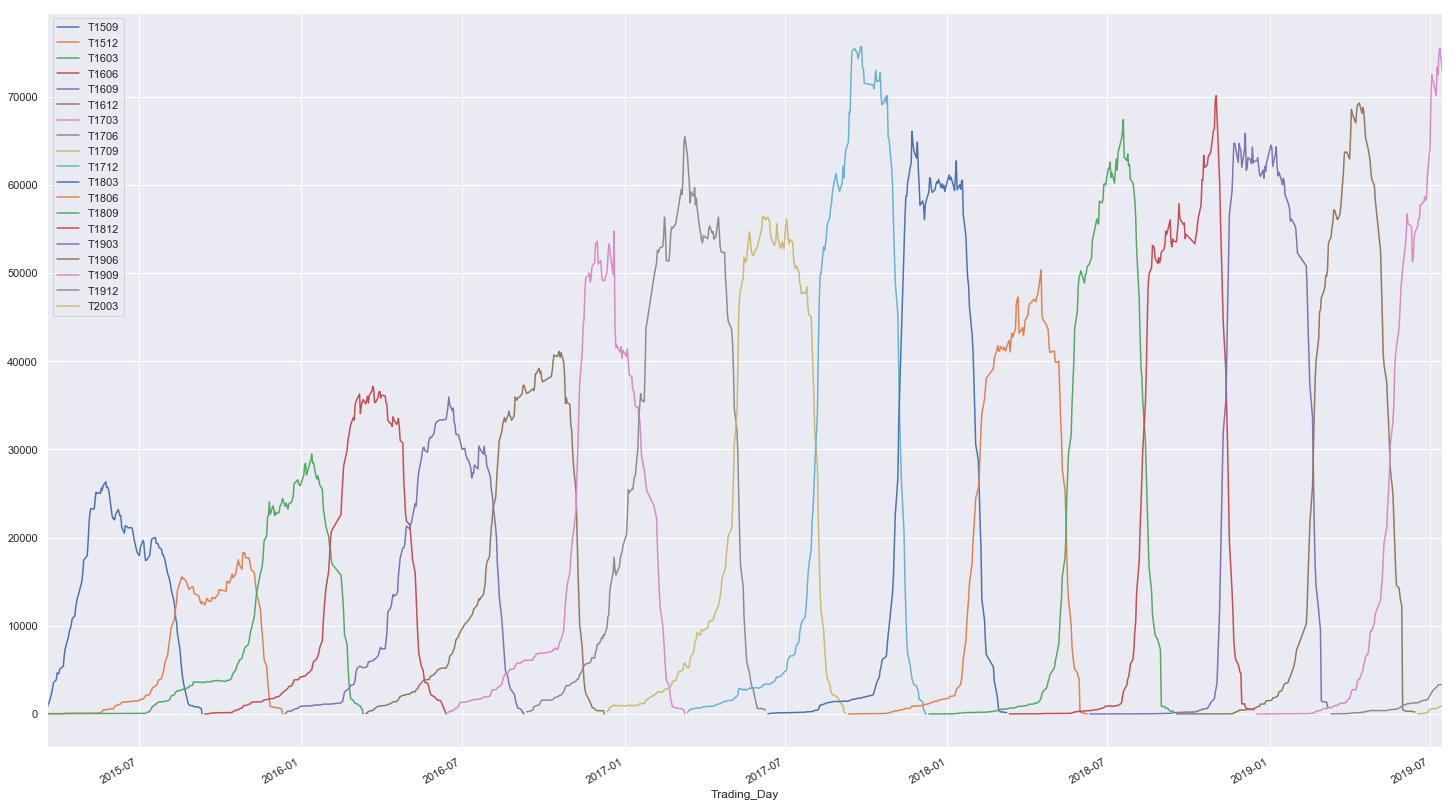

In [9]:
# plot open interest of T
T_dfs[-1].plot()

In [10]:
date_df = pd.read_csv(r'..\data\raw\meta_data\delivery_info.csv', index_col=0, parse_dates=['intention_day', 'notice_day', 'delivery_day'], infer_datetime_format=True, keep_date_col=True)

In [11]:
TS_intention_day = date_df['intention_day'][date_df.index.str.match('TS')]
TF_intention_day = date_df['intention_day'][date_df.index.str.match('TF')]
T_intention_day = date_df['intention_day'][~date_df.index.str.match('TS|TF')]

In [12]:
# get list of intention days
T_intention_list = list(T_intention_day.values)
TF_intention_list = list(TF_intention_day.values)
TS_intention_list = list(TS_intention_day.values)

# T open interest

In [13]:
# get index list for markevery
def get_case(idx, idx_list):
    sr = pd.Series(range(len(idx)), index=idx)
    return list(sr.reindex(idx_list).dropna().astype('int').values)

In [14]:
case = get_case(T_dfs[-1].index, T_intention_list)

In [15]:
# case of n days before intention day 
case_2days_ealier = [num - 2 for num in case]
case_6days_ealier = [num - 6 for num in case]
case_16days_ealier = [num - 16 for num in case]
case_20days_ealier = [num - 20 for num in case]

D:\anaconda\lib\site-packages\matplotlib\lines.py:196: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


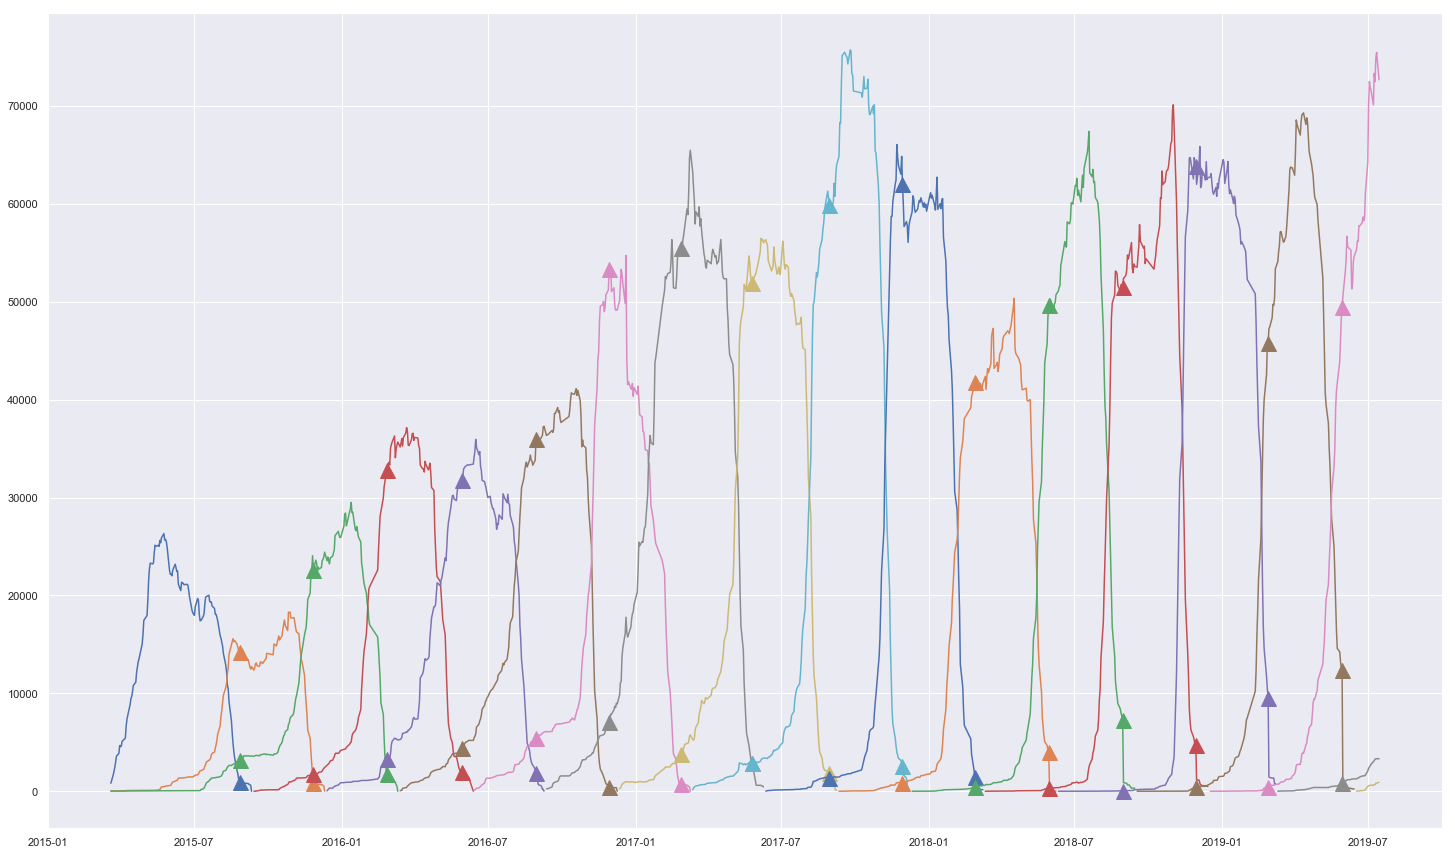

In [16]:
# intention days are marked by triangle
plt.plot(T_dfs[-1].index, T_dfs[-1].values, '^', ls='-', ms=15, markevery=[case])
plt.show()

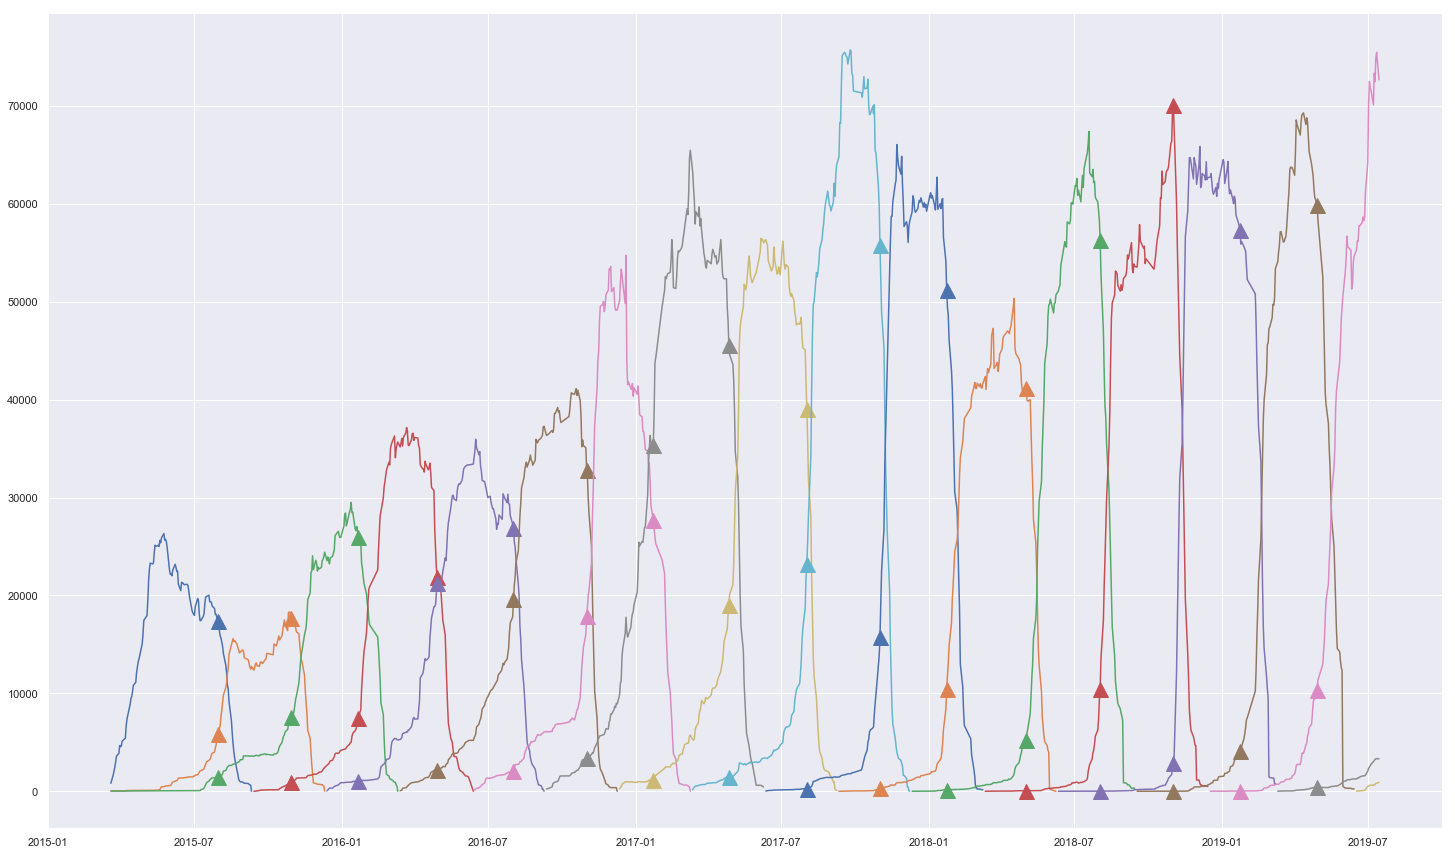

In [17]:
# 20 days before the intention day
plt.plot(T_dfs[-1].index, T_dfs[-1].values, '^', ls='-', ms=15, markevery=[case_20days_ealier])
plt.show()

# T open interest fraction

In [18]:
T_OI = T_dfs[-1].copy()
T_OI = T_OI.div(T_OI.sum(axis=1), axis=0)

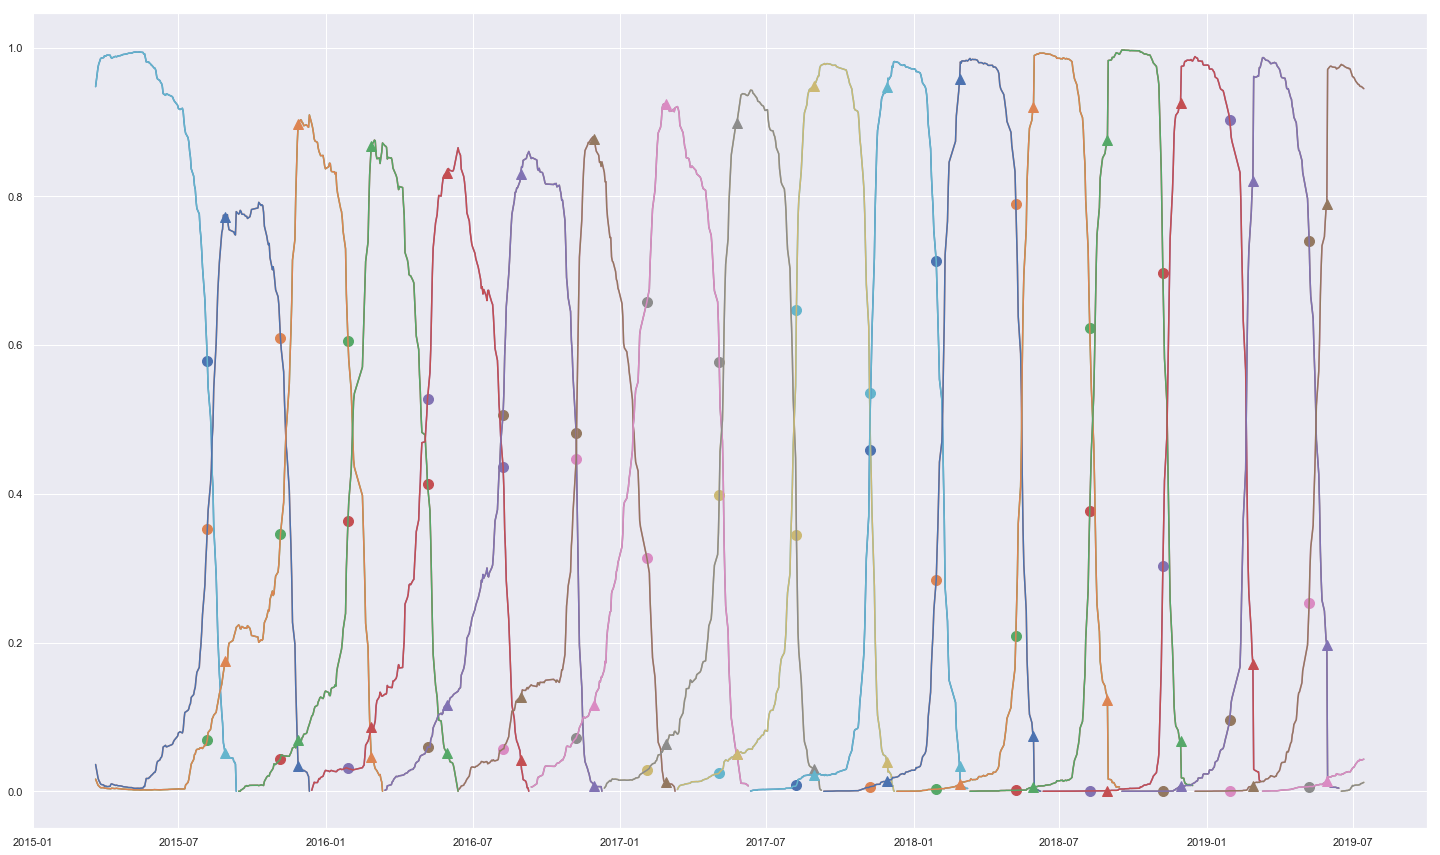

In [19]:
# 16 days before intention day is marked by a dot
plt.plot(T_OI.index, T_OI.values, '.', ls='-', ms=20, markevery=[case_16days_ealier])
plt.plot(T_OI.index, T_OI.values, '^', ls='-', ms=10, markevery=[case])
plt.show()

# Open interest change in different season

In [20]:
# ignore exact date, plot open interest fraction by season

i = 0

for name in T_OI.columns:
    
    sr = pd.DataFrame(T_OI[name].dropna())
    idx = sr.index
    sr['idx'] = range(len(idx))
    intention_day = date_df.loc[name, 'intention_day']
    
    if intention_day in sr.index:
        num = sr.loc[intention_day, 'idx']
    else:
        continue
    
    sr['idx'] = sr['idx'] - num
    sr.index = sr['idx']
    sr = sr.drop(columns=['idx'])

    if i == 0:
        T_intention_df = sr
    else:
        T_intention_df = pd.concat([T_intention_df, sr], axis=1)
        
    i = i + 1

In [21]:
col = pd.Series(T_intention_df.columns)
col.index = [x[-2:] for x in col]

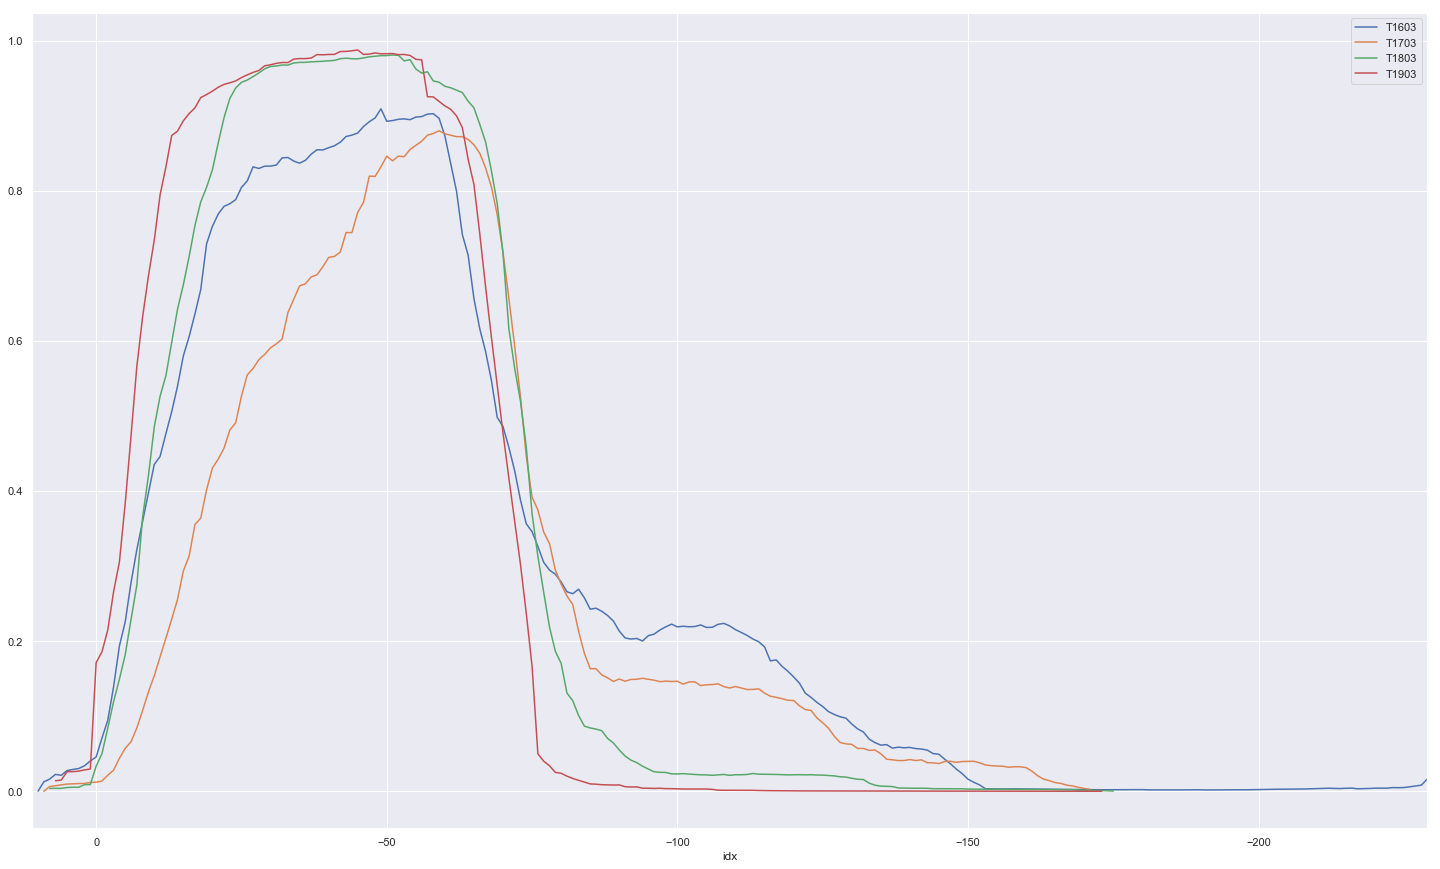

In [22]:
ax = T_intention_df.reindex(columns = col.loc['03'].values).plot()
ax.invert_xaxis()

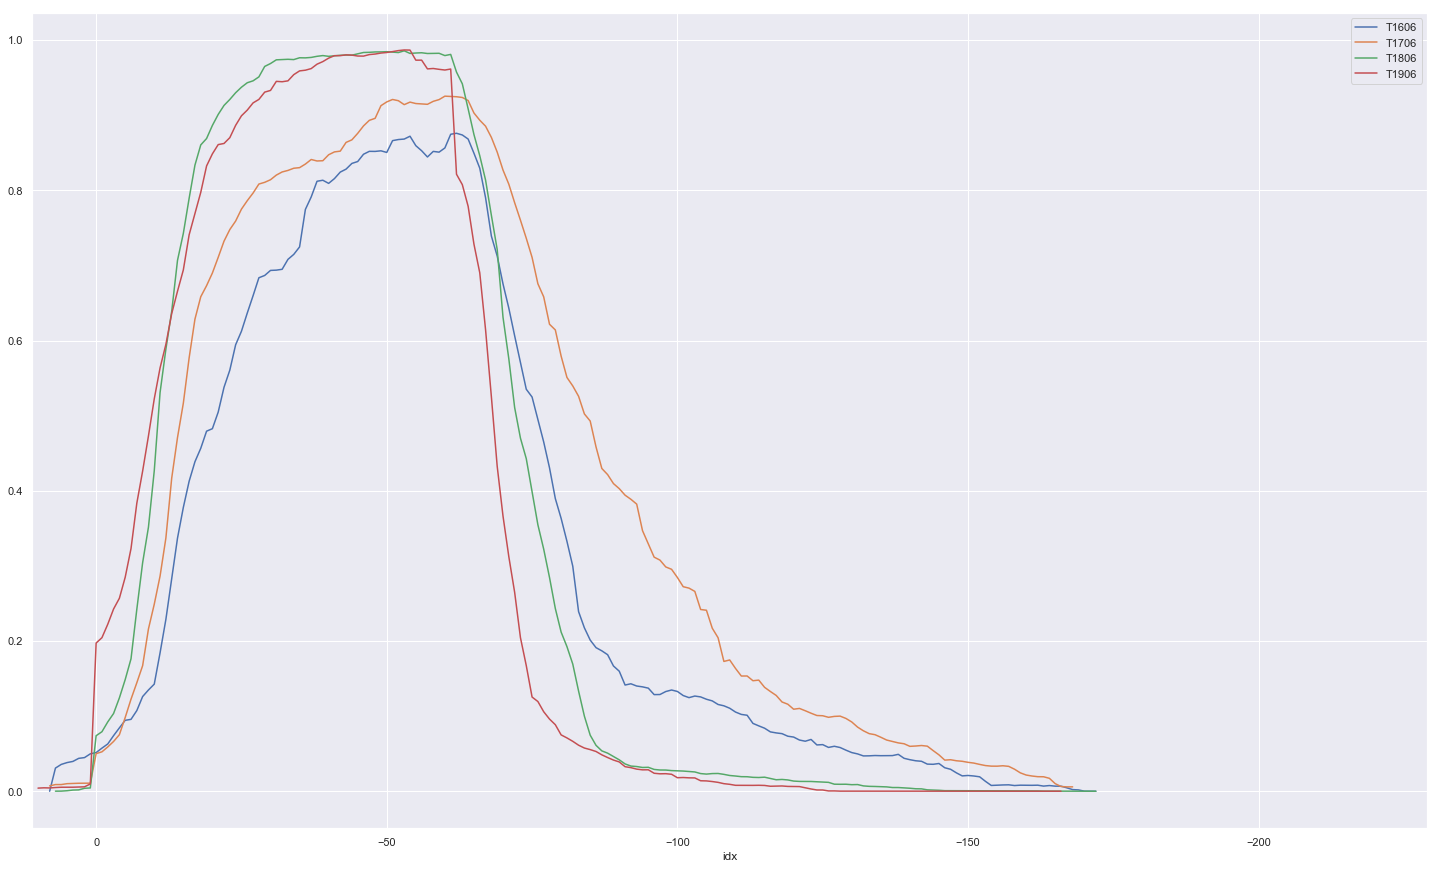

In [23]:
ax = T_intention_df.reindex(columns = col.loc['06'].values).plot()
ax.invert_xaxis()

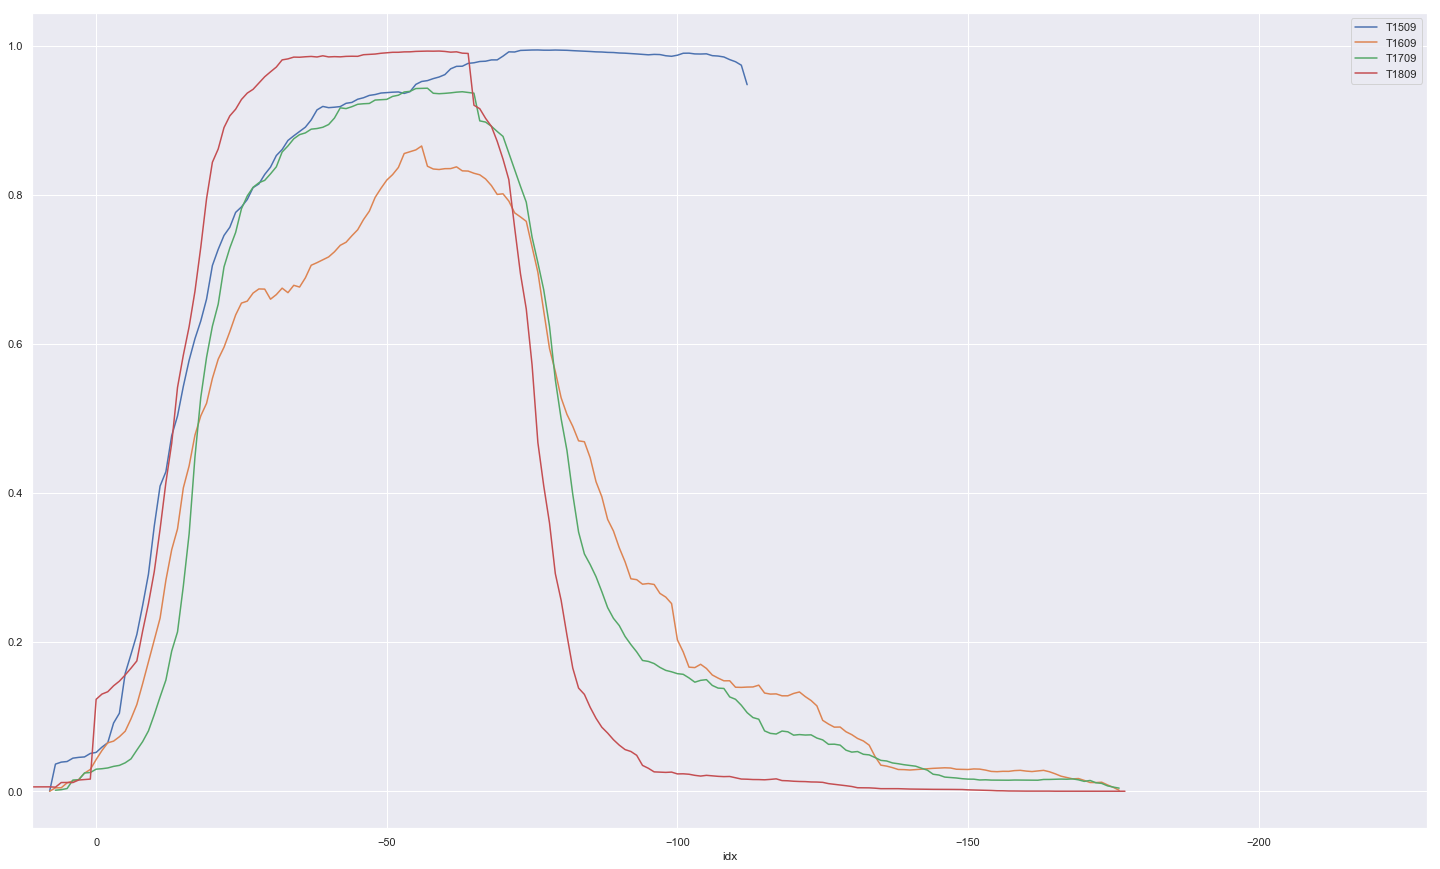

In [24]:
ax = T_intention_df.reindex(columns = col.loc['09'].values).plot()
ax.invert_xaxis()

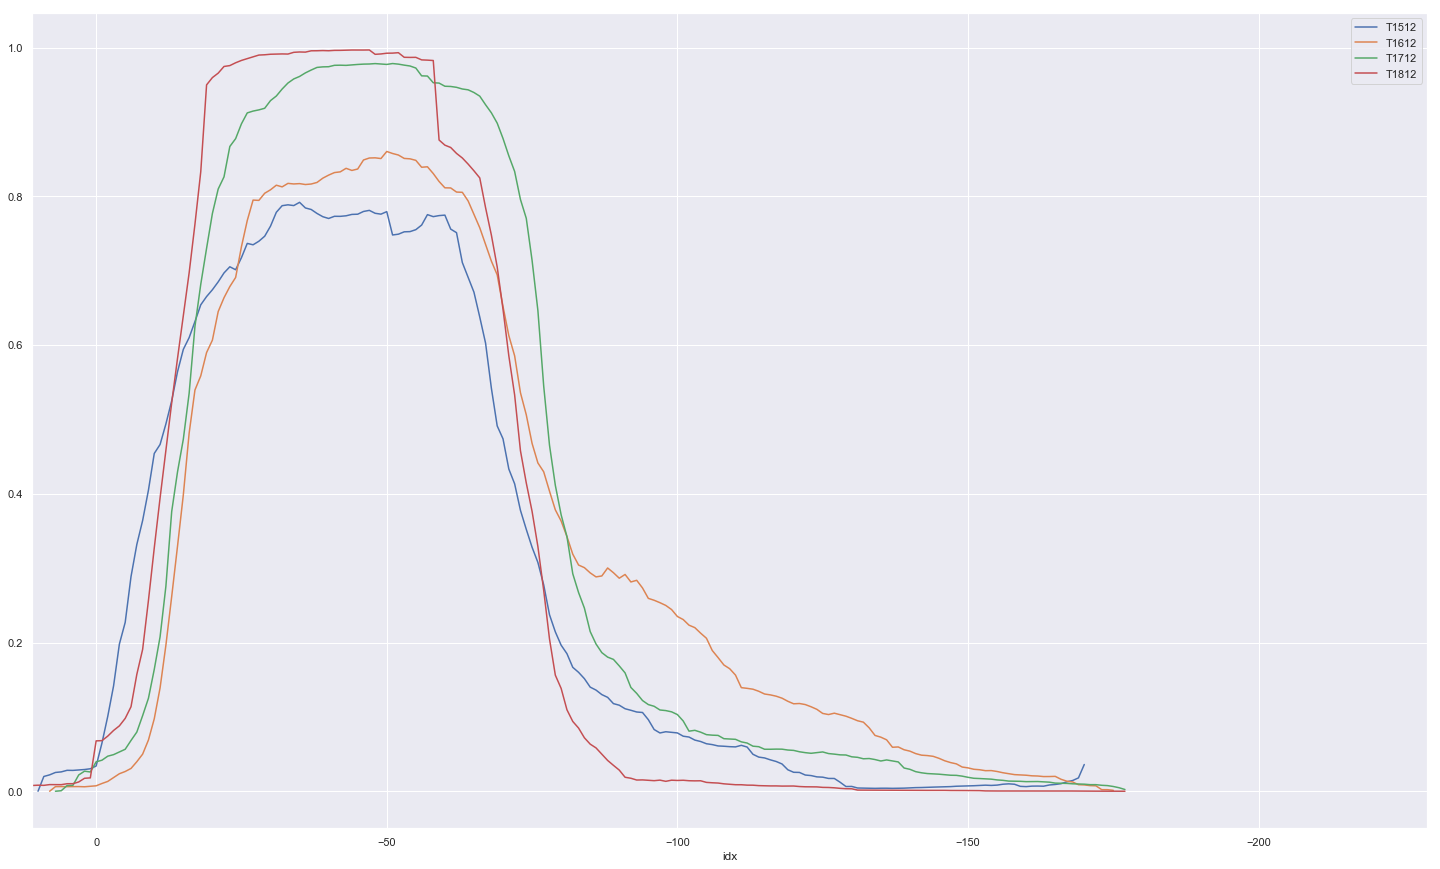

In [25]:
ax = T_intention_df.reindex(columns = col.loc['12'].values).plot()
ax.invert_xaxis()

# TF

In [26]:
TF_OI = TF_dfs[-1].copy()
TF_OI = TF_OI.div(TF_OI.sum(axis=1), axis=0)

In [27]:
i = 0

for name in TF_OI.columns:
    sr = pd.DataFrame(TF_OI[name].dropna())
    idx = sr.index
    sr['idx'] = range(len(idx))
    intention_day = date_df.loc[name, 'intention_day']
    
    if intention_day in sr.index:
        num = sr.loc[intention_day, 'idx']
    else:
        continue
    
    sr['idx'] = sr['idx'] - num
    sr.index = sr['idx']
    sr = sr.drop(columns=['idx'])

    if i == 0:
        TF_intention_df = sr
    else:
        TF_intention_df = pd.concat([TF_intention_df, sr], axis=1)
        
    i = i + 1

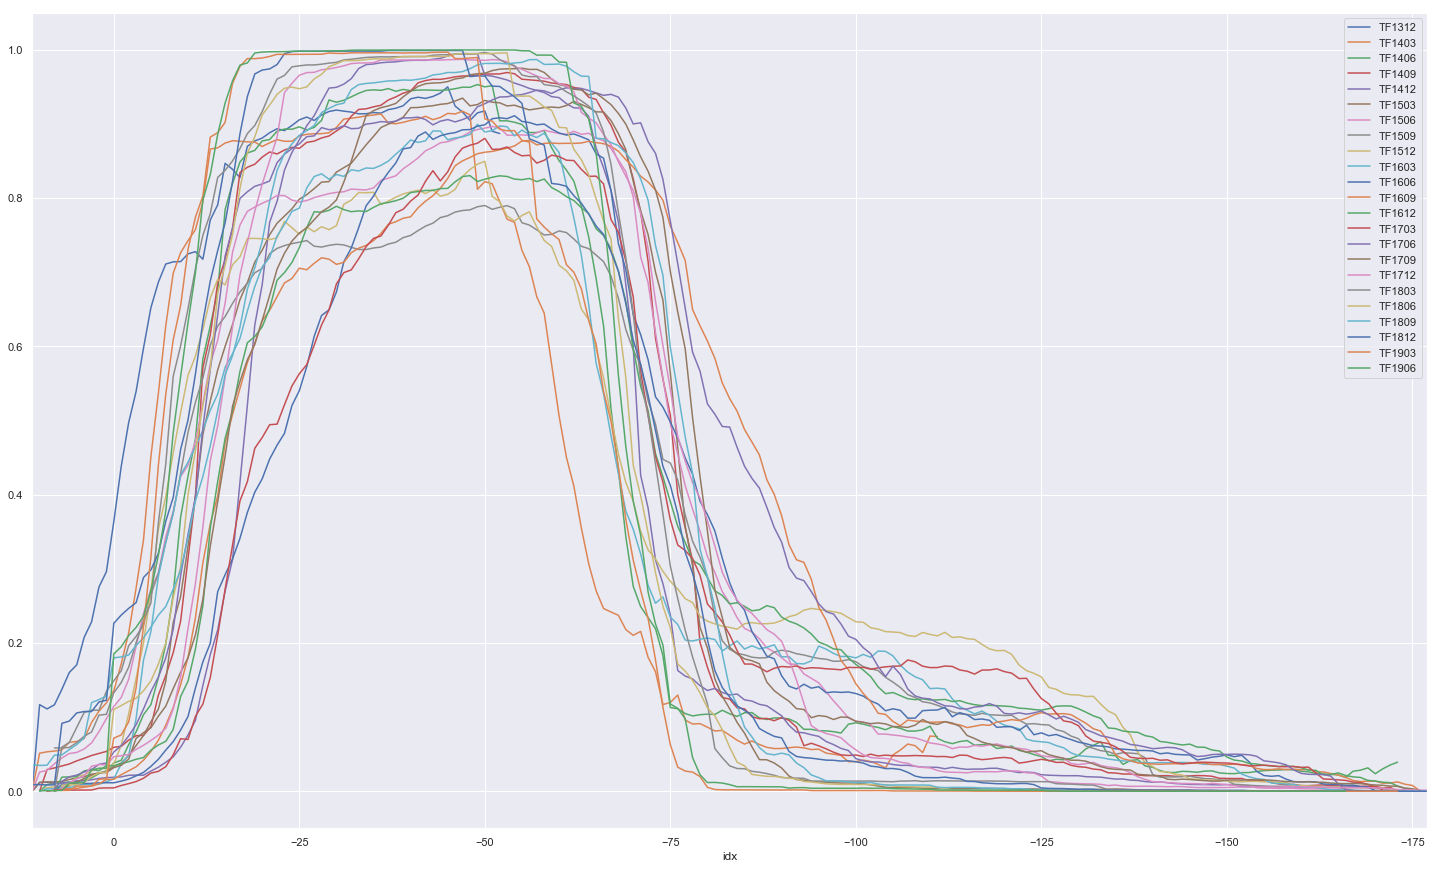

In [28]:
ax = TF_intention_df.plot()
ax.invert_xaxis()

In [29]:
TF_col = pd.Series(TF_intention_df.columns)
TF_col.index = [x[-2:] for x in TF_col]

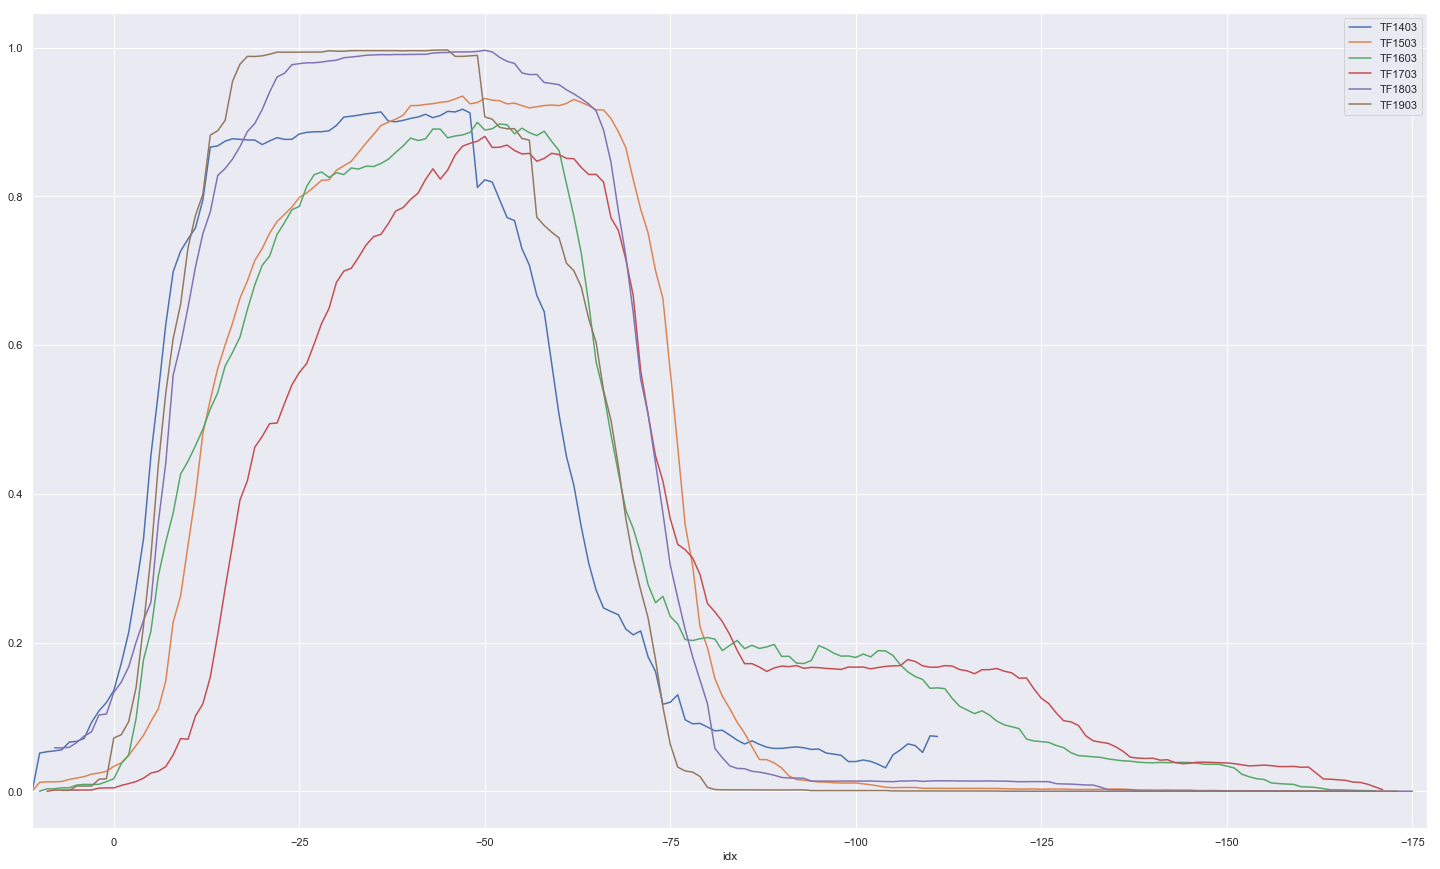

In [30]:
ax = TF_intention_df.reindex(columns = TF_col.loc['03'].values).plot()
ax.invert_xaxis()